In [1]:
!pip install pyyaml==5.1

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

fatal: destination path 'detectron2' already exists and is not an empty directory.


/tmp/ipykernel_8705/4085003363.py:1: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import sys, os, distutils.core


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# extract files
!unzip '/home/umair-pc/Downloads/archive.zip'

In [4]:
# specify path
path='data/'
# list down the folders 
folders = os.listdir(path)
print(folders)

['pullshot', 'legglance-flick', 'drive', 'sweep']


In [5]:
# for dealing with images
import cv2
# create lists
images  = []
labels  = []
# for each folder
for folder in folders:
    # list down image names
    names=os.listdir(path+folder)
    # for each image
    for name in names:
        # read an image
        img=cv2.imread(path+folder+'/'+name)
        # append image to list
        images.append(img)       
        # append folder name (type of shot) to list
        labels.append(folder)

In [6]:
# number of images
len(images)

694

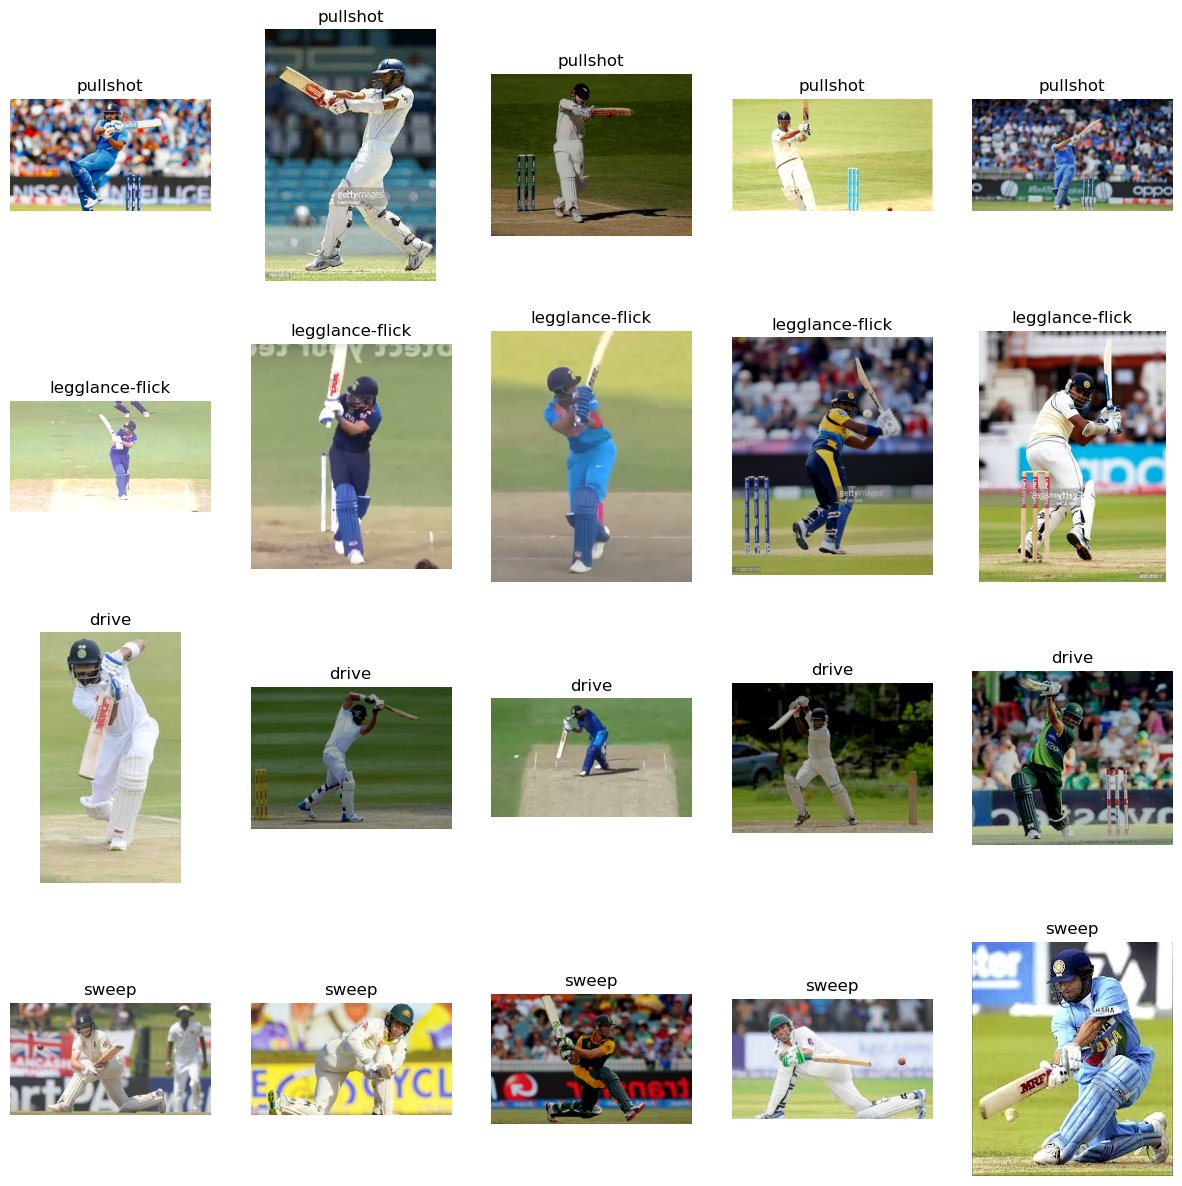

In [7]:
# visualization library
import matplotlib.pyplot as plt
# for randomness
import random
# create subplots with 4 rows and 5 columns
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,15))
# randomly display 5 images for each shot for each folder
for i in range(len(folders)):
    # read image names
    names=os.listdir(path+folders[i])
    # randomly select 5 image names
    names= random.sample(names, 5)
    # for each image
    for j in range(len(names)):
      # read an image 
      img = cv2.imread(path+ folders[i]+ '/' +names[j])
      # convert BGR to RGB
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      # display image
      ax[i, j].imshow(img)
      # set folder name as title
      ax[i, j].set_title(folders[i])
      # Turn off axis
      ax[i, j].axis('off')

In [8]:
# import some common detectron2 utilities to obtain pretrained models
from detectron2 import model_zoo
# set up predictor
from detectron2.engine import DefaultPredictor
# set config
from detectron2.config import get_cfg
# define configure instance
cfg = get_cfg()
# get a model specified by relative path under Detectron2’s official configs/ directory.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
# download pretrained model 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
# set threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
# create predictor
predictor = DefaultPredictor(cfg)

/home/umair-pc/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


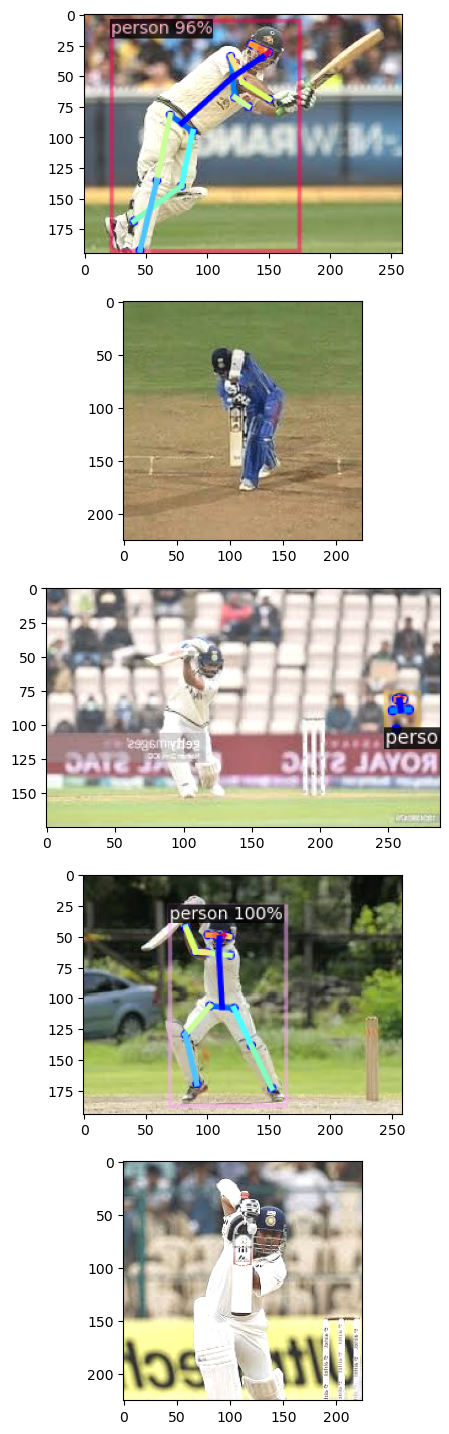

In [9]:
# for drawing predictions on images
from detectron2.utils.visualizer import Visualizer
# to obtain metadata
from detectron2.data import MetadataCatalog
# to display an image
#from google.colab.patches import cv2_imshow

fig, ax = plt.subplots(nrows=5 ,figsize=(18,18))
i=0
# randomly select images
for img in random.sample(images,5):    
    # make predictions
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    outputs = predictor(img)
    # use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
    # draw prediction on image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # display image
    #cv2_imshow(v.get_image()[:, :, ::-1])
    ax[i].imshow(v.get_image()[:, :, ::-1])
    i=i+1

In [10]:
# define function that extracts the keypoints for an image
def extract_keypoints(img):  
  # make predictions
  outputs = predictor(img)
  # fetch keypoints
  keypoints = outputs['instances'].pred_keypoints
  # convert to numpy array
  kp = keypoints.cpu().numpy()
  # if keypoints detected
  if(len(keypoints)>0):
    # fetch keypoints of a person with maximum confidence score
    kp = kp[0]
    kp = np.delete(kp,2,1)
    # convert 2D array to 1D array
    kp = kp.flatten()
    # return keypoints
    return kp

# progress bar
from tqdm import tqdm
import numpy as np
# create list
keypoints   = []
# for every image
for i in tqdm(range(len(images))): 
  # extract keypoints
  kp = extract_keypoints(images[i]) 
  # append keypoints 
  keypoints.append(kp)

100%|█████████████████████████████████████████| 694/694 [13:00<00:00,  1.12s/it]


In [11]:
a=keypoints

In [12]:
keypoints=a
len(keypoints)

694

In [13]:
#remove none
#keypoints = [kp for kp in keypoints if kp is not None]
#repllace with zero
keypoints = [kp if kp is not None else np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) for kp in keypoints]

In [14]:
len(keypoints)

694

In [15]:
keypoints[-8:]

[array([223.8517  ,  42.66581 , 233.2971  ,  38.38867 , 220.92813 ,
         32.985973, 233.2971  ,  43.116035, 207.6596  ,  26.907936,
        224.0766  ,  64.27661 , 176.39984 ,  38.8389  , 219.35391 ,
         89.489204, 150.53745 ,  49.419186, 206.08537 ,  95.79236 ,
        175.0505  ,  94.44169 , 183.59633 , 154.54672 , 120.85191 ,
         85.21207 , 157.28416 , 112.90091 , 104.43491 , 160.39964 ,
        189.89325 , 160.39964 , 103.76025 , 160.39964 ], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([162.23694 ,  47.227997, 164.0448  ,  44.063175, 160.65504 ,
         43.385   , 161.78497 ,  44.515293, 150.03389 ,  39.089886,
        147.77406 ,  58.53093 , 136.02296 ,  44.289238, 148.22603 ,
         79.5544  , 147.77406 ,  71.8684  , 158.6212  ,  97.41304 ,
        169.2424  ,  95.37851 , 105.289345,  90.40522 , 100.54371 ,
         89.500984, 153.19763 , 100.803925, 152.2937  , 101

In [16]:
# for normalization
from sklearn.preprocessing import StandardScaler
# define normalizer
scaler= StandardScaler()
# normalize keypoints
keypoints = scaler.fit_transform(keypoints)
# convert to an array
keypoints = np.array(keypoints)

In [17]:
# converting the target categories into numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(labels)

In [77]:
# Now, you want to see which label corresponds to which number
original_labels = le.inverse_transform(y)

# Printing the mapping between labels and numbers
for label, number in zip(original_labels, y):
    print(f"{label} --> {number}")

pullshot --> 2
pullshot --> 2
sweep --> 3
pullshot --> 2
pullshot --> 2
drive --> 0
legglance-flick --> 1
sweep --> 3
legglance-flick --> 1
pullshot --> 2
drive --> 0
legglance-flick --> 1
sweep --> 3
legglance-flick --> 1
pullshot --> 2
drive --> 0
pullshot --> 2
sweep --> 3
drive --> 0
pullshot --> 2
pullshot --> 2
pullshot --> 2
drive --> 0
pullshot --> 2
drive --> 0
legglance-flick --> 1
drive --> 0
drive --> 0
pullshot --> 2
drive --> 0
sweep --> 3
drive --> 0
pullshot --> 2
sweep --> 3
legglance-flick --> 1
sweep --> 3
drive --> 0
legglance-flick --> 1
drive --> 0
pullshot --> 2
sweep --> 3
sweep --> 3
drive --> 0
pullshot --> 2
legglance-flick --> 1
pullshot --> 2
legglance-flick --> 1
drive --> 0
sweep --> 3
pullshot --> 2
sweep --> 3
pullshot --> 2
pullshot --> 2
drive --> 0
sweep --> 3
legglance-flick --> 1
drive --> 0
pullshot --> 2
drive --> 0
pullshot --> 2
sweep --> 3
pullshot --> 2
legglance-flick --> 1
sweep --> 3
drive --> 0
drive --> 0
drive --> 0
legglance-flick --> 

In [18]:
# for creating training and validation sets
from sklearn.model_selection import train_test_split
# split keypoints and labels in 80:20
x_tr, x_val, y_tr, y_val = train_test_split(keypoints, y, test_size=0.2, stratify=labels, random_state=120)

In [19]:
# converting the keypoints and target value to tensor
import torch
x_tr = torch.Tensor(x_tr)
x_val = torch.Tensor(x_val)
y_tr = torch.Tensor(y_tr)
y_tr = y_tr.type(torch.long)
y_val = torch.Tensor(y_val)
y_val = y_val.type(torch.long)

In [20]:
# shape of training and validation set
(x_tr.shape, y_tr.shape), (x_val.shape, y_val.shape)

((torch.Size([555, 34]), torch.Size([555])),
 (torch.Size([139, 34]), torch.Size([139])))

In [21]:
# importing libraries for defining the architecture of model
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear, ReLU, Sequential, Softmax, CrossEntropyLoss
# defining the model architecture
model = Sequential(Linear(34, 64),
                   ReLU(),
                   Linear(64, 4),
                   Softmax()
                   )

In [22]:
# define optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [23]:
#Additionally, we are also printing the validation loss after every 10th epoch.

def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(x_tr), Variable(y_tr)
    # getting the validation set
    x_valid, y_valid = Variable(x_val), Variable(y_val)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_valid = x_valid.cuda()
        y_valid = y_valid.cuda()
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_valid)
    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_valid)
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    if epoch%10 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, 't', 'loss :', loss_val.item())

In [24]:
# defining the number of epochs
n_epochs = 100
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 t loss : 1.3886696100234985
Epoch :  11 t loss : 1.2129466533660889
Epoch :  21 t loss : 1.1611634492874146
Epoch :  31 t loss : 1.1161139011383057
Epoch :  41 t loss : 1.0638073682785034
Epoch :  51 t loss : 1.0362517833709717
Epoch :  61 t loss : 1.0138282775878906
Epoch :  71 t loss : 0.9908560514450073
Epoch :  81 t loss : 0.9773234724998474
Epoch :  91 t loss : 0.9708282947540283


/home/umair-pc/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [25]:
# to check the model performance
from sklearn.metrics import accuracy_score
# get validation accuracy
x, y = Variable(x_val), Variable(y_val)
if torch.cuda.is_available():
  x_val = x.cuda()
  y_val = y.cuda()
pred = model(x_val)
final_pred = np.argmax(pred.cpu().data.numpy(), axis=1)
accuracy_score(y_val.cpu(), final_pred)

0.7913669064748201

In [26]:
model

Sequential(
  (0): Linear(in_features=34, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=4, bias=True)
  (3): Softmax(dim=None)
)

In [27]:
images[0]

array([[[150, 138, 115],
        [132, 121,  98],
        [106,  96,  82],
        ...,
        [ 47,  42,  43],
        [ 47,  43,  42],
        [ 42,  38,  37]],

       [[138, 127, 103],
        [120, 108,  85],
        [ 94,  84,  67],
        ...,
        [ 58,  53,  54],
        [ 53,  49,  48],
        [ 45,  41,  40]],

       [[122, 111,  85],
        [104,  94,  67],
        [ 77,  68,  49],
        ...,
        [ 66,  62,  63],
        [ 53,  49,  48],
        [ 40,  36,  35]],

       ...,

       [[152, 191, 202],
        [152, 191, 202],
        [152, 191, 202],
        ...,
        [114, 176, 158],
        [114, 176, 158],
        [121, 183, 164]],

       [[157, 196, 207],
        [157, 196, 207],
        [157, 196, 207],
        ...,
        [110, 174, 156],
        [108, 175, 156],
        [113, 177, 159]],

       [[149, 188, 199],
        [149, 188, 199],
        [149, 188, 199],
        ...,
        [110, 177, 158],
        [108, 177, 158],
        [107, 174, 155]]

In [97]:
image_path = "/home/umair-pc/data/pullshot/image214.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image
kpp= extract_keypoints(image)

In [98]:
kpp = scaler.transform(kpp.reshape(1, -1))

In [99]:
#kpp = scaler.transform(kpp)
# convert to an array
kpp = np.array(kpp)
x_t = torch.Tensor(kpp)
if torch.cuda.is_available():
        image = x_t.cuda()
        #image = x_t.cuda().unsqueeze(0)
pred = model(image)
predicc = np.argmax(pred.cpu().data.numpy(), axis=1)
print(predicc[0])
shot_types = ['drive', 'legglance-flick', 'pullshot', 'sweep']
predicted_shot = shot_types[predicc[0]]
print(f"Predicted shot: {predicted_shot}")

2
Predicted shot: pullshot


/home/umair-pc/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [101]:
def prediction(image):
    #image = cv2.imread(image_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    kpp= extract_keypoints(image)

    kpp = scaler.transform(kpp.reshape(1, -1))


    kpp = np.array(kpp)
    x_t = torch.Tensor(kpp)
    if torch.cuda.is_available():
            image = x_t.cuda()
            #image = x_t.cuda().unsqueeze(0)
    pred = model(image)
    predicc = np.argmax(pred.cpu().data.numpy(), axis=1)
    #print(predicc[0])
    shot_types = ['drive', 'legglance-flick', 'pullshot', 'sweep']
    predicted_shot = shot_types[predicc[0]]
    return predicted_shot
    #print(f"Predicted shot: {predicted_shot}")

/home/umair-pc/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/umair-pc/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/umair-pc/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/umair-pc/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/umair-pc/.local/lib/python3.10/site-packages/torch/nn/modules/containe

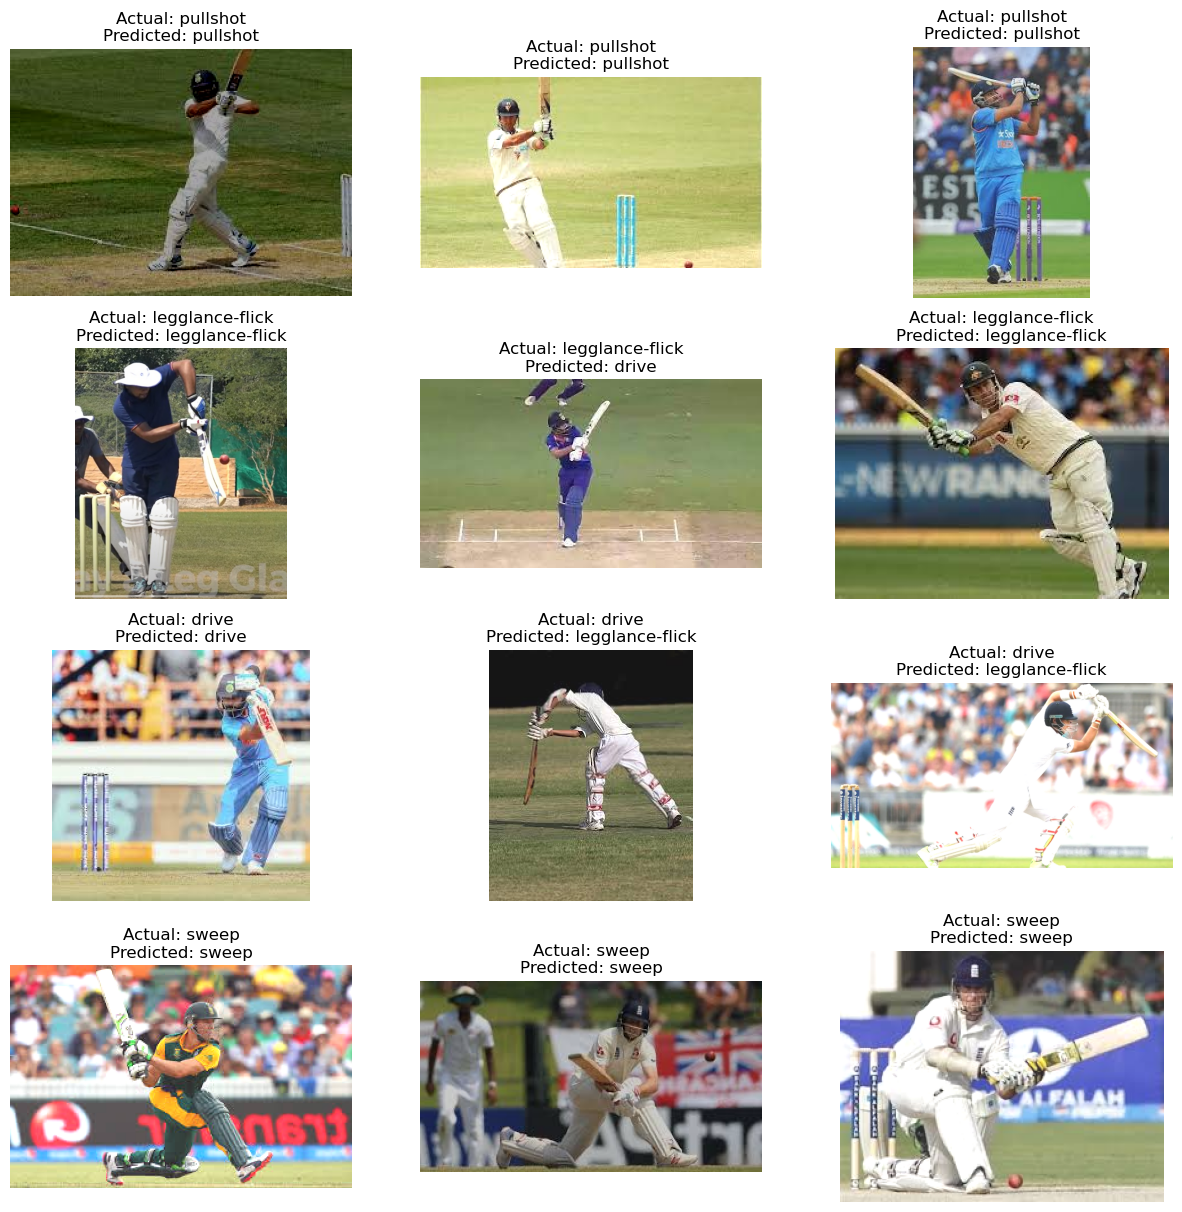

In [113]:
# visualization library
import matplotlib.pyplot as plt
# for randomness
import random
# create subplots with 4 rows and 5 columns
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
# randomly display 5 images for each shot for each folder
for i in range(len(folders)):
    # read image names
    names=os.listdir(path+folders[i])
    # randomly select 5 image names
    names= random.sample(names, 3)
    # for each image
    for j in range(len(names)):
      # read an image 
      img = cv2.imread(path+ folders[i]+ '/' +names[j])
      # convert BGR to RGB
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      actual_label = folders[i]
      predicted_label = prediction(img)
      # display image
      ax[i, j].imshow(img)
      # set folder name as title
      ax[i, j].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
      # Turn off axis
      ax[i, j].axis('off')

In [ ]:

print(torch.cuda.is_available())
print(torch.cuda.get_device_properties(0).total_memory)